[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


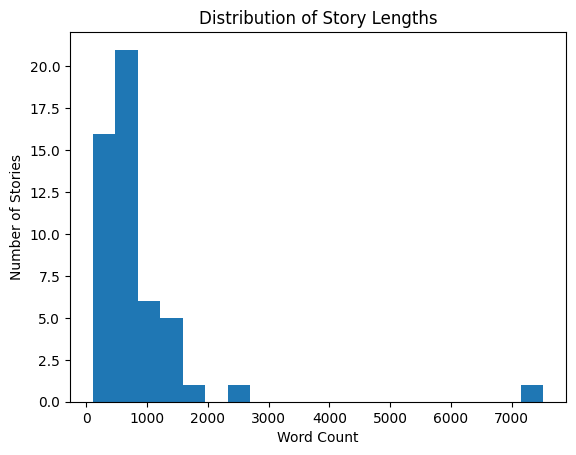

Sample cleaned text:
0    Our forefathers have told us much of the comin...
Name: clean_text, dtype: object
Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_entity_dictionary.csv'.
Auto-labeled DataFrame shape: (49656, 4)
Saved auto-labeled NER data to 'auto_ner_data.csv'.
Grouped DataFrame shape: (2044, 4)
   doc_id  sentence_id                                             token

Map: 100%|██████████| 409/409 [00:00<00:00, 18362.20 examples/s]


Processed datasets ready for training.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_26644/4252213788.py:338: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.030500,0.010451,0.904762,0.987013,0.944099,0.998167
2,0.012500,0.008965,0.904762,0.987013,0.944099,0.997583


/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Inference output:
[{'entity_group': 'PER', 'score': 0.9710044, 'word': 'Nukúnguasik', 'start': 0, 'end': 11}, {'entity_group': 'PER', 'score': 0.7703736, 'word': 'Ikerssuaq', 'start': 26, 'end': 35}, {'entity_group': 'PER', 'score': 0.7509668, 'word': 'Nuuk', 'start': 39, 'end': 43}]


In [ ]:
############################
# 1. SETUP & IMPORTS
############################

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Adjust for your MPS backend
import torch

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('words')
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

############################
# 2. LOAD & EXPLORE DATA
############################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################
# 3. CLEAN THE TEXT
############################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:")
print(df["clean_text"].head(1))

############################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
for table in soup_towns.find_all("table", class_="wikitable"):
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################
# 5. LOAD MANUALLY CURATED CSV & MERGE WITH SCRAPED DATA
############################

# The CSV "candidate_entities_finished.csv" should have columns:
# "entity_candidate", "entity" (e.g., "Ikerssuaq,B-LOC")
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    manual_dict = dict(zip(manual_df["entity_candidate"].str.lower(), manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

# Merge: manual data takes precedence; add scraped names and towns if not present.
entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"  # Default scraped personal names as beginning of PER
for town in scraped_towns:
    key = town.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"  # Default scraped town names as beginning of LOC

print("Final Entity Dictionary (sample):")
for k, v in list(sorted(entity_dict.items()))[:20]:
    print(f"{k}: {v}")

# Save final entity dictionary for review.
final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################
# 6. AUTO-LABEL TEXT USING THE ENTITY DICTIONARY (BIO FORMAT)
############################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    # Extract entity type from label (assumes label like "B-PER")
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
print("Auto-labeled DataFrame shape:", auto_ner_df.shape)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING
############################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })

df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

# Split into training and validation sets (80/20 split)
train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################
# 8. TOKENIZATION & LABEL ALIGNMENT
############################

# Define a full BIO label list.
label_list = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i, words in enumerate(examples["tokens"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        previous_word_idx = None
        for idx, word_id in enumerate(word_ids):
            if word_id is None:
                aligned_labels.append(-100)
            else:
                # If the token is part of the same word as the previous token,
                # and the word's label is not "O", set it to I- if not first token.
                if word_id == previous_word_idx and example_labels[word_id] != "O":
                    # Convert B- label to I- if needed.
                    label = example_labels[word_id]
                    if label.startswith("B-"):
                        label = "I-" + label[2:]
                    aligned_labels.append(label2id.get(label, 0))
                else:
                    aligned_labels.append(label2id.get(example_labels[word_id], 0))
                previous_word_idx = word_id
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("Processed datasets ready for training.")

############################
# 9. TRAINING THE NER MODEL
############################

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        tmp_true_labels = []
        tmp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            tmp_true_labels.append(id2label[l_i])
            tmp_true_preds.append(id2label[p_i])
        if tmp_true_labels:
            true_labels.append(tmp_true_labels)
            true_preds.append(tmp_true_preds)
    if not true_labels:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results.get("overall_precision", 0.0),
        "recall": results.get("overall_recall", 0.0),
        "f1": results.get("overall_f1", 0.0),
        "accuracy": results.get("overall_accuracy", 1.0)
    }

# Use a custom data collator to ensure no extra keys are passed.
class MinimalDataCollator(DataCollatorForTokenClassification):
    def __call__(self, features):
        batch = super().__call__(features)
        # Remove any extraneous keys if present
        for k in list(batch.keys()):
            if k not in {"input_ids", "attention_mask", "labels", "token_type_ids", "special_tokens_mask"}:
                batch.pop(k, None)
        return batch

data_collator = MinimalDataCollator(tokenizer, padding=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # Disable fp16 on MPS
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################
# 10. INFERENCE
############################

from transformers import pipeline
ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("Inference output:")
print(ner_infer(test_text))


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


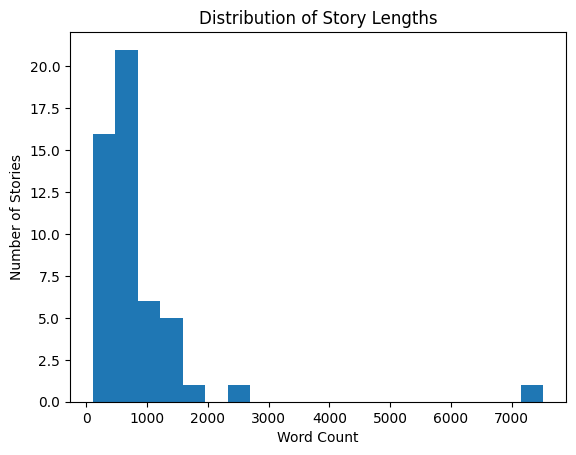

Sample cleaned text:
0    Our forefathers have told us much of the comin...
Name: clean_text, dtype: object
Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_entity_dictionary.csv'.
Auto-labeled DataFrame shape: (49656, 4)
Saved auto-labeled NER data to 'auto_ner_data.csv'.
Grouped DataFrame shape: (2044, 4)
   doc_id  sentence_id                                             token

Map: 100%|██████████| 409/409 [00:00<00:00, 7024.11 examples/s]


Processed datasets ready for training.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_26644/1580203717.py:318: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

In [ ]:
############################################
# 1. SETUP & IMPORTS
############################################
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Adjust for your MPS backend
import torch
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('words')
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

############################################
# 2. LOAD & EXPLORE DATA
############################################
df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################
def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:")
print(df["clean_text"].head(1))

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM WEB
############################################
# a) Personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# b) Town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
for table in soup_towns.find_all("table", class_="wikitable"):
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUAL CANDIDATE CSV
############################################
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    manual_dict = dict(zip(manual_df["entity_candidate"].str.lower(), manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"
for town in scraped_towns:
    key = town.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"

print("Final Entity Dictionary (sample):")
for k, v in list(sorted(entity_dict.items()))[:20]:
    print(f"{k}: {v}")

final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL TEXT WITH BIO USING THE ENTITY DICTIONARY
############################################
def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_ent = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_ent if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
print("Auto-labeled DataFrame shape:", auto_ner_df.shape)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING
############################################
grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 8. TOKENIZATION & LABEL ALIGNMENT
############################################
label_list = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i, words in enumerate(examples["tokens"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        previous_word_idx = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            else:
                if word_id == previous_word_idx and example_labels[word_id] != "O":
                    # Change a B- label to I- for subsequent subword tokens.
                    label = example_labels[word_id]
                    if label.startswith("B-"):
                        label = "I-" + label[2:]
                    aligned_labels.append(label2id.get(label, 0))
                else:
                    aligned_labels.append(label2id.get(example_labels[word_id], 0))
                previous_word_idx = word_id
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("Processed datasets ready for training.")
print(processed_datasets)

############################################
# 9. TRAINING THE NER MODEL
############################################
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        tmp_true_labels = []
        tmp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            tmp_true_labels.append(id2label[l_i])
            tmp_true_preds.append(id2label[p_i])
        if tmp_true_labels:
            true_labels.append(tmp_true_labels)
            true_preds.append(tmp_true_preds)
    if not true_labels:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results.get("overall_precision", 0.0),
        "recall": results.get("overall_recall", 0.0),
        "f1": results.get("overall_f1", 0.0),
        "accuracy": results.get("overall_accuracy", 1.0)
    }

# A minimal data collator that removes extra keys.
class MinimalDataCollator(DataCollatorForTokenClassification):
    def __call__(self, features):
        batch = super().__call__(features)
        for key in list(batch.keys()):
            if key not in {"input_ids", "attention_mask", "labels", "token_type_ids", "special_tokens_mask"}:
                batch.pop(key, None)
        return batch

data_collator = MinimalDataCollator(tokenizer, padding=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # Disable fp16 on MPS
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################################
# 10. INFERENCE
############################################
from transformers import pipeline

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("Inference output:")
print(ner_infer(test_text))


In [3]:
auto_ner_df["ner_label"].value_counts()

ner_label
O         49211
B-PER       390
B-MISC       44
B-LOC        10
B-O           1
Name: count, dtype: int64

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


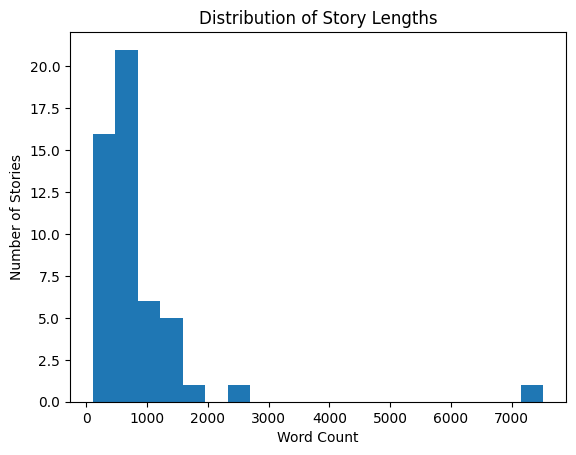

Sample cleaned text:
0    Our forefathers have told us much of the comin...
Name: clean_text, dtype: object
Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER

Checking 'nuuk' => B-LOC
Checking 'ikerssuaq' => B-LOC
Auto-labeled DataFrame shape: (49656, 4)
Saved auto-labeled NER data to 'auto_ner_data.csv'.

Label distribution in auto-labeled data:
ner_label
O         49211
B-PER       390
B-MISC       44
B-LOC        10
B-O           1
Name: count, dtype: int64
Grouped DataFrame shape: (2044, 4)
Train size: (1635, 4)
Validation size: (409, 4)


Map: 100%|██████████| 409/409 [00:00<00:00, 15539.95 examples/s]


Processed datasets ready for training.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_38399/4032551669.py:333: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.026400,0.016364,0.915663,0.987013,0.950000,0.997583
2,0.011800,0.015543,0.892857,0.974026,0.931677,0.997417
3,0.009200,0.017112,0.915663,0.987013,0.950000,0.997500
4,0.005200,0.018240,0.915663,0.987013,0.950000,0.997500


OSError: greenlandic_ner_model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
############################
# 1. SETUP & IMPORTS
############################
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

import torch
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('words')

import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from transformers import (
    pipeline, 
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

############################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################
df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################
# 3. CLEAN TEXT
############################
def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:")
print(df["clean_text"].head(1))

############################
# 4. SCRAPE CANDIDATE ENTITIES
############################
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")

scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")

scraped_towns = set()
for table in soup_towns.find_all("table", class_="wikitable"):
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit","coordinate","article","statement","isbn",
                    "list of","administrative","autonomy","history","portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################
# 5. LOAD MANUAL CSV & MERGE
############################
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    manual_dict = dict(zip(manual_df["entity_candidate"].str.lower(), manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()

for name in scraped_names:
    key = name.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"

for town in scraped_towns:
    key = town.lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"

# CRUCIAL: Ensure "nuuk" => "B-LOC", "ikerssuaq" => "B-LOC"
print("\nChecking 'nuuk' =>", entity_dict.get("nuuk"))
print("Checking 'ikerssuaq' =>", entity_dict.get("ikerssuaq"))

############################
# 6. AUTO-LABEL WITH BIO
############################
def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    # Extract the entity type from e.g. "B-LOC" => "LOC"
    ent_type = label.split("-", 1)[-1]
    if prev_entity == ent_type:
        return f"I-{ent_type}", ent_type
    else:
        return f"B-{ent_type}", ent_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_ent = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_ent if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)

print("Auto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################
# (Optional) Distribution Check
############################
print("\nLabel distribution in auto-labeled data:")
print(auto_ner_df["ner_label"].value_counts())

############################
# 7. GROUP TOKENS PER SENTENCE
############################
grouped = auto_ner_df.groupby(["doc_id","sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })

df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################
# 8. TOKENIZE & ALIGN LABELS
############################
label_list = ["O","B-PER","I-PER","B-LOC","I-LOC","B-MISC","I-MISC"]
label2id = {lbl:i for i,lbl in enumerate(label_list)}
id2label = {i:lbl for lbl,i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i, words in enumerate(examples["tokens"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        previous_word_idx = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            else:
                # If same word as previous subword, convert B- => I- for that subword
                if word_id == previous_word_idx and example_labels[word_id] != "O":
                    label = example_labels[word_id]
                    if label.startswith("B-"):
                        label = "I-" + label[2:]
                    aligned_labels.append(label2id.get(label,0))
                else:
                    aligned_labels.append(label2id.get(example_labels[word_id],0))
                previous_word_idx = word_id
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)

print("Processed datasets ready for training.")
print(processed_datasets)

############################
# 9. TRAINING
############################
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row,label_row in zip(predictions,labels):
        tmp_true_labels = []
        tmp_true_preds = []
        for p_i,l_i in zip(pred_row,label_row):
            if l_i == -100:
                continue
            tmp_true_labels.append(id2label[l_i])
            tmp_true_preds.append(id2label[p_i])
        if tmp_true_labels:
            true_labels.append(tmp_true_labels)
            true_preds.append(tmp_true_preds)
    if not true_labels:
        return {"precision":0.0,"recall":0.0,"f1":0.0,"accuracy":1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

class MinimalDataCollator(DataCollatorForTokenClassification):
    def __call__(self, features):
        batch = super().__call__(features)
        keep_keys = {"input_ids","attention_mask","labels","token_type_ids","special_tokens_mask"}
        for k in list(batch.keys()):
            if k not in keep_keys:
                batch.pop(k,None)
        return batch

data_collator = MinimalDataCollator(tokenizer, padding=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,  # Increase epochs to help location class
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

best_model = trainer.model
best_model.eval()
best_model.half()

save_path = "greenlandic_ner_model_fp16"
best_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)




In [2]:
############################
# 10. INFERENCE
############################
from transformers import pipeline

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model_fp16",
    tokenizer="greenlandic_ner_model_fp16",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output:")
print(ner_infer(test_text))

Device set to use mps:0



Inference output:
[{'entity_group': 'PER', 'score': 0.9886085, 'word': 'Nukúnguasik', 'start': 0, 'end': 11}, {'entity_group': 'PER', 'score': 0.7009339, 'word': 'I', 'start': 26, 'end': 27}, {'entity_group': 'LOC', 'score': 0.28212953, 'word': 'kers', 'start': 27, 'end': 31}, {'entity_group': 'PER', 'score': 0.9799397, 'word': 'suaq', 'start': 31, 'end': 35}, {'entity_group': 'PER', 'score': 0.8069587, 'word': 'Nuuk', 'start': 39, 'end': 43}]


In [3]:
from collections import Counter
label_counts = Counter(auto_ner_df["ner_label"])
print(label_counts)


Counter({'O': 49211, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10, 'B-O ': 1})


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


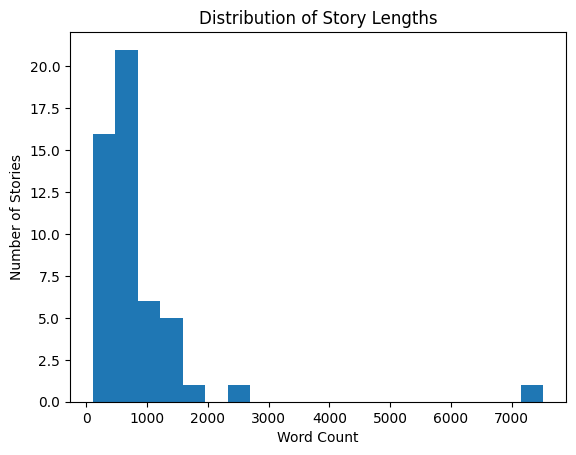


Sample cleaned text:
 Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Loaded dictionary. Sample:
  entity_candidate  entity
0            ailaq   B-PER
1             aluk   B-PER
2           alátaq   B-PER
3         amerdloq   B-PER
4          anarteq   B-PER
5           angiut  B-MISC
6     angmagssalik   B-LOC
7    angusinãnguaq   B-PER
8            artuk   B-PER
9           asalôq   B-PER

Check 'nuuk': B-LOC
Check 'ikerssuaq': B-LOC

Auto-labeled DataFrame shape: (49656, 4)
Saved to 'auto_ner_data.csv'

Grouped DataFrame shape: (2044, 4)
   doc_id  sentence_id                                             tokens  \
0       0            0  [Our, forefathers, have, told, us, much, of, t...   
1       0            1  [Those, who, liv

Map: 100%|██████████| 409/409 [00:00<00:00, 7105.40 examples/s]



Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49211, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10, 'B-O ': 1})
Weights: tensor([2.0320e-05, 2.5575e-03, 1.0000e+00, 9.0909e-02, 1.0000e+00, 2.2222e-02,
        1.0000e+00])


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_38399/2312735759.py:270: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedNERTra

TypeError: WeightedNERTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'

In [4]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
# For Apple M-series users, allow more memory usage on MPS if desired
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

import torch
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from collections import Counter
from torch.nn import functional as F

# Hugging Face
from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

############################################
# 2. NLTK SETUP & LOAD FOLKTALES
############################################
nltk.download('punkt')
nltk.download('words')

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

# Quick EDA: distribution of text lengths
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN TEXT
############################################
def clean_text_for_ner(text: str) -> str:
    """
    Basic cleanup: unify line endings, remove extra spaces, etc.
    """
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        # Remove multiple newlines inside each paragraph
        para = re.sub(r'\n+', ' ', para)
        # Normalize or remove fancy quotes/dashes
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        # Remove extra spaces
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("\nSample cleaned text:\n", df["clean_text"].iloc[0][:300], "...")

############################################
# 4. LOAD DICTIONARY & (OPTIONAL) SCRAPE DATA
############################################
# If you have a CSV with your final dictionary, load it:
final_dict_path = "final_entity_dictionary.csv"  # or "candidate_entities_finished.csv"
dictionary_df = pd.read_csv(final_dict_path)
print("\nLoaded dictionary. Sample:")
print(dictionary_df.head(10))

# Convert to a Python dict: token.lower() -> 'B-PER' / 'B-LOC' / ...
entity_dict = dict(zip(dictionary_df["entity_candidate"].str.lower(), dictionary_df["entity"]))

# Debug check: e.g. 'nuuk' or 'ikerssuaq'
print("\nCheck 'nuuk':", entity_dict.get("nuuk"))
print("Check 'ikerssuaq':", entity_dict.get("ikerssuaq"))

############################################
# 5. AUTO-LABEL FOLKTALES WITH BIO TAGS
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    """
    Assign a B- or I- tag based on dictionary lookups.
    If token not found, label = 'O'.
    If found, label = 'B-XXX' or 'I-XXX' depending on previous entity.
    """
    token_lower = token.lower()
    # 1) Direct match or remove trailing 's' if it ends with s
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"

    # If not recognized, done
    if label == "O":
        return "O", None

    # e.g. if label = "B-LOC", then entity_type = "LOC"
    entity_type = label.split("-", 1)[-1]

    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio(text, entity_dict):
    """
    Convert raw text -> list of (token, label) via dictionary-based BIO labeling.
    """
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity_type = None
        for token in tokens:
            bio_label, current_type = get_entity_label_bio(token, entity_dict, prev_entity_type)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity_type = current_type if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    labeled = auto_label_bio(row["clean_text"], entity_dict)
    for item in labeled:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved to 'auto_ner_data.csv'")

############################################
# 6. GROUP BY SENTENCE -> TRAINING EXAMPLES
############################################
grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })

df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head(5))

############################################
# 7. SPLIT TRAIN / VAL
############################################
train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 8. DEFINE LABELS & TOKENIZE
############################################
# Suppose your domain has at least these labels:
label_list = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# (A) Add known tokens so "Ikerssuaq" or "Nuuk" won't be subword-split
#     For simplicity, let's add all dictionary tokens of length > 4
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added:", num_added)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                # Retrieve label: e.g. "B-LOC"
                original_label = example_labels[wid]
                if wid == prev_wid and original_label != "O":
                    # Convert B-xxx to I-xxx
                    if original_label.startswith("B-"):
                        original_label = "I-" + original_label[2:]
                aligned_labels.append(label2id.get(original_label, 0))
                prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 9. SHOW LABEL DISTRIBUTION & BUILD WEIGHT
############################################
# We'll collect the final label distribution from auto_ner_df

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)

# Example weighting approach:
# For each label in label2id, weight = 1 / (count_of_label + 1)
weight_list = [0]*len(label_list)
for lbl, idx in label2id.items():
    c = label_counts.get(lbl, 0)
    # Avoid 1/0 -> 1/(c+1)
    weight_list[idx] = 1.0 / (c+1)

weight_tensor = torch.tensor(weight_list, dtype=torch.float)
print("Weights:", weight_tensor)

############################################
# 10. BUILD CUSTOM TRAINER WITH WEIGHTED LOSS
############################################
class WeightedNERTrainer(Trainer):
    def __init__(self, *args, weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = weight

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: [batch_size, seq_len, num_labels]

        # Flatten
        loss_mask = (labels != -100)
        active_logits = logits.view(-1, self.model.config.num_labels)
        active_labels = torch.where(
            loss_mask.view(-1), 
            labels.view(-1),
            torch.tensor(-100, device=labels.device)
        )

        # Weighted cross entropy
        loss = F.cross_entropy(
            active_logits,
            active_labels,
            weight=self.weight,
            ignore_index=-100
        )
        return (loss, outputs) if return_outputs else loss

# Metric
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        temp_true_labels = []
        temp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            temp_true_labels.append(id2label[l_i])
            temp_true_preds.append(id2label[p_i])
        if temp_true_labels:
            true_labels.append(temp_true_labels)
            true_preds.append(temp_true_preds)
    if not true_labels:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

############################################
# 11. MODEL INIT & TRAIN
############################################
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Must resize embeddings since we added special tokens
model.resize_token_embeddings(len(tokenizer))

model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",  # or "steps"
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,  # more epochs to help minority classes
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # on Apple MPS, keep fp16 off
    remove_unused_columns=False
)

trainer = WeightedNERTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer, padding=True),
    weight=weight_tensor,  # Weighted cross-entropy
    compute_metrics=compute_metrics
)

trainer.train()

############################################
# 12. SAVE MODEL & TEST
############################################
trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

# Quick test
inference_pipeline = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference on sample:", test_text)
print(inference_pipeline(test_text))


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


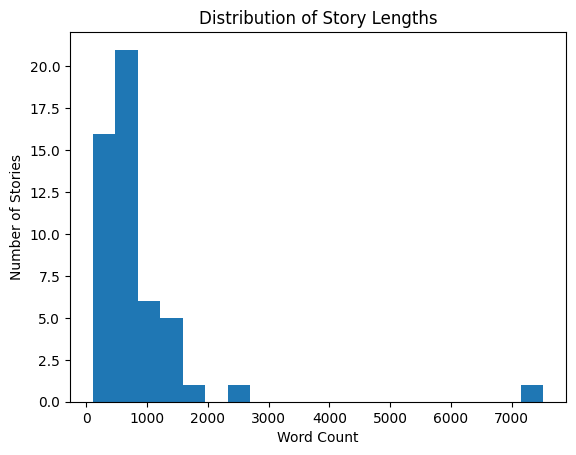

Sample cleaned text:
Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_entit

Map: 100%|██████████| 409/409 [00:00<00:00, 7178.36 examples/s]
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49212, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10})
Weight tensor: tensor([2.0320e-05, 2.5575e-03, 9.0909e-02, 2.2222e-02])


/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_38399/50814932.py:359: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedNERTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedNERTrainer(


TypeError: Trainer.__init__() got an unexpected keyword argument 'weight'

In [5]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Adjust for Apple MPS

import torch
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate
import torch.nn.functional as F

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('words')

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    # Unify line endings and split into paragraphs
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        # Normalize quotes/dashes
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:")
print(df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                # Filter out common wiki noise
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD MANUALLY CURATED CANDIDATE CSV & MERGE WITH SCRAPED DATA
############################################

# Load manually curated candidate CSV (assumed to be in BIO format)
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    # Clean the columns: remove extra whitespace & make keys lowercase
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip()
    # Fix any erroneous label (e.g., "B-O" becomes "O")
    manual_df["entity"] = manual_df["entity"].replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

# Merge manual data takes precedence over scraped
entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"

print("Final Entity Dictionary (sample):")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

# Save dictionary for review
final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS USING DICTIONARY (BIO FORMATTING)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):  # simple plural handling
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"

    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("Auto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN / VALIDATION & CREATE DatasetDict
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define label list (include all needed BIO tags)
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# --- Add all known dictionary tokens to tokenizer to prevent subword-splitting ---
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("Number of special tokens added:", num_added)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                # For same-word sub-token, convert B- tag to I- tag if applicable
                label_str = example_labels[wid]
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("Processed datasets ready for training:")
print(processed_datasets)

############################################
# 10. PRINT LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)

# Compute weight: weight = 1/(count+1) for each label index
weight_list = [1.0/(label_counts.get(lbl,0)+1) for lbl in label_list]
weight_tensor = torch.tensor(weight_list, dtype=torch.float)
print("Weight tensor:", weight_tensor)

############################################
# 11. DEFINE CUSTOM WEIGHTED TRAINER
############################################

class WeightedNERTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove unwanted key if present
        kwargs.pop("num_items_in_batch", None)
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, seq_len, num_labels]
        loss_mask = (labels != -100)
        active_logits = logits.view(-1, self.model.config.num_labels)
        active_labels = torch.where(
            loss_mask.view(-1),
            labels.view(-1),
            torch.tensor(-100, device=labels.device)
        )
        loss = F.cross_entropy(
            active_logits,
            active_labels,
            weight=self.weight,
            ignore_index=-100
        )
        return (loss, outputs) if return_outputs else loss

############################################
# 12. MODEL INIT & TRAINING SETUP
############################################

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
# Resize embeddings because we added special tokens.
model.resize_token_embeddings(len(tokenizer))
model.gradient_checkpointing_enable()  # reduces memory usage

# Optionally compile model if using torch 2.0+ (MPS should be okay)
if hasattr(torch, "compile"):
    model = torch.compile(model)

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # on MPS, keep fp16 disabled
    remove_unused_columns=False
)

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

trainer = WeightedNERTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    weight=weight_tensor,
    compute_metrics=(
        lambda p: evaluate.load("seqeval").compute(
            predictions=[
                [id2label[label] for label in pred if label != -100] 
                for pred in np.argmax(p[0], axis=2)
            ],
            references=[
                [id2label[label] for label in gold if label != -100] 
                for gold in p[1]
            ],
            zero_division=0
        )
    )
)

print("\nStarting training...")
trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################################
# 13. INFERENCE
############################################

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


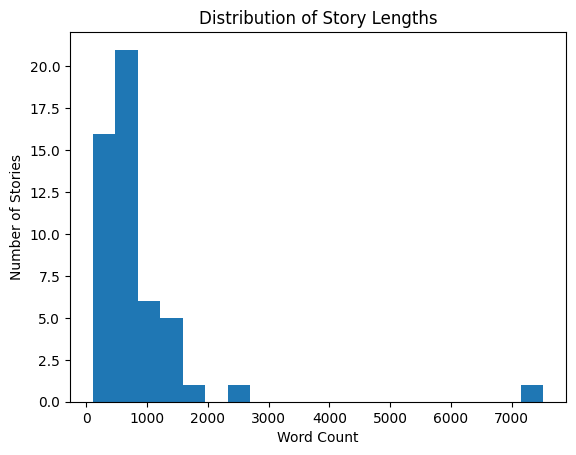

Sample cleaned text:
 Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_enti

Map: 100%|██████████| 409/409 [00:00<00:00, 7130.23 examples/s]



Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49212, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10})
Weight tensor: tensor([2.0320e-05, 2.5575e-03, 9.0909e-02, 2.2222e-02])


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_38399/284644772.py:352: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedNERTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedNERTrainer(



Starting training...


BackendCompilerFailed: backend='inductor' raised:
LoweringException: TypeError: 'NoneType' object is not callable
  target: aten.cumsum.default
  args[0]: TensorBox(StorageBox(
    Pointwise(
      'mps',
      torch.int32,
      def inner_fn(index):
          i0, i1 = index
          tmp0 = ops.load(primals_1, i1 + 65 * i0)
          tmp1 = ops.constant(1, torch.int64)
          tmp2 = tmp0 != tmp1
          tmp3 = ops.to_dtype(tmp2, torch.int32, src_dtype=torch.bool)
          return tmp3
      ,
      ranges=[8, 65],
      origin_node=convert_element_type,
      origins=OrderedSet([convert_element_type, ne])
    )
  ))
  args[1]: 1

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [7]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Adjust for your Apple MPS backend
import torch
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter
import torch.nn.functional as F

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download required NLTK resources
nltk.download('punkt')
nltk.download('words')

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:\n", df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                        "edit", "coordinate", "article", "statement", "isbn",
                        "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUALLY CURATED CANDIDATE CSV
############################################

try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip().replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"

print("Final Entity Dictionary (sample):")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS (BIO FORMAT)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN/VALIDATION & CREATE DatasetDict
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define label list (using standard BIO tags)
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# --- Add all dictionary keys (special tokens) to tokenizer ---
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added:", num_added)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                label_str = example_labels[wid]
                # If token is a subsequent subword token of the same word, change B- to I-
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 10. SHOW LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)

# Compute weight for each label as 1/(count+1)
weight_list = [1.0 / (label_counts.get(lbl, 0) + 1) for lbl in label_list]
weight_tensor = torch.tensor(weight_list, dtype=torch.float)
print("Weight tensor:", weight_tensor)

############################################
# 11. DEFINE CUSTOM WEIGHTED TRAINER
############################################

class WeightedNERTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove any extraneous keyword arguments
        kwargs.pop("num_items_in_batch", None)
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, seq_length, num_labels]
        loss_mask = (labels != -100)
        active_logits = logits.view(-1, self.model.config.num_labels)
        active_labels = torch.where(
            loss_mask.view(-1),
            labels.view(-1),
            torch.tensor(-100, device=labels.device)
        )
        loss = F.cross_entropy(
            active_logits,
            active_labels,
            weight=self.weight,
            ignore_index=-100
        )
        return (loss, outputs) if return_outputs else loss

############################################
# 12. MODEL INIT & TRAINING SETUP
############################################

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
# Resize embeddings to account for new special tokens.
model.resize_token_embeddings(len(tokenizer))
model.gradient_checkpointing_enable()  # Reduce memory usage

# Try compiling the model; if it fails, suppress errors and fall back to eager mode.
if hasattr(torch, "compile"):
    try:
        model = torch.compile(model)
    except Exception as e:
        print("Model compilation failed, falling back to eager mode.")
        import torch._dynamo
        torch._dynamo.config.suppress_errors = True

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # Disable fp16 on MPS
    remove_unused_columns=False
)

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

trainer = WeightedNERTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda p: evaluate.load("seqeval").compute(
        predictions=[
            [id2label[label] for label in np.argmax(p[0], axis=2)[i] if label != -100]
            for i in range(len(p[1]))
        ],
        references=[
            [id2label[label] for label in p[1][i] if label != -100]
            for i in range(len(p[1]))
        ],
        zero_division=0
    )
)
# Set weight tensor on trainer (used in compute_loss)
trainer.weight = weight_tensor

print("\nStarting training...")
trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################################
# 13. INFERENCE
############################################

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))


/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


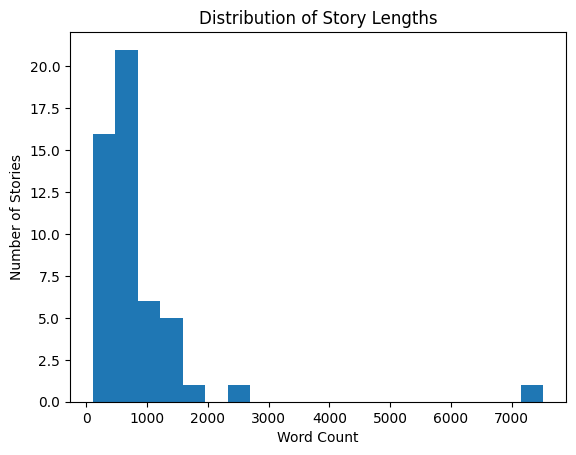

Sample cleaned text:
 Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_enti

Map: 100%|██████████| 409/409 [00:00<00:00, 17595.11 examples/s]


Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49212, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10})
Weight tensor: tensor([2.0320e-05, 2.5575e-03, 9.0909e-02, 2.2222e-02])



Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_41146/2525380503.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__ini


Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.001600,0.001830,0.926829,0.987013,0.955975,0.999500
2,0.003400,0.001813,0.986842,0.974026,0.980392,0.999833
3,0.000200,0.007599,0.835165,0.987013,0.904762,0.998750
4,0.000000,0.002441,0.938272,0.987013,0.962025,0.999583


Device set to use mps:0



Inference output on sample text:
[{'entity_group': 'PER', 'score': 0.99882084, 'word': 'Nuk', 'start': 0, 'end': 3}, {'entity_group': 'LOC', 'score': 0.98761046, 'word': 'I', 'start': 26, 'end': 27}, {'entity_group': 'LOC', 'score': 0.7367588, 'word': 'Nu', 'start': 39, 'end': 41}]


In [1]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Allow up to 90% of MPS memory

import torch
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter

import torch.nn.functional as F

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download required NLTK resources
nltk.download('punkt')
nltk.download('words')

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:\n", df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                # Skip typical noisy links
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUALLY CURATED CANDIDATE CSV
############################################

try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    # Standardize: strip and lower-case keys; fix any O labels
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip().replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"  # Default scraped personal names as B-PER
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"  # Default scraped town names as B-LOC

print("Final Entity Dictionary (sample):")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS USING ENTITY DICTIONARY (BIO FORMAT)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN/VALIDATION & CREATE DATASETS
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define label list (using standard BIO tags)
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# Add special tokens from our entity dictionary to the tokenizer to avoid undesired subword splitting.
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added:", num_added)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                label_str = example_labels[wid]
                # For contiguous subword tokens of the same original word, convert B- to I-
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False  # disable caching to save disk space
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 10. SHOW LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)

# Compute weights for each label as 1/(count+1)
weight_list = [1.0 / (label_counts.get(lbl, 0) + 1) for lbl in label_list]
weight_tensor = torch.tensor(weight_list, dtype=torch.float)
print("Weight tensor:", weight_tensor)

############################################
# 11. TRAIN THE CUSTOM NER MODEL
############################################

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        temp_true_labels = []
        temp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            temp_true_labels.append(id2label[l_i])
            temp_true_preds.append(id2label[p_i])
        if temp_true_labels:
            true_labels.append(temp_true_labels)
            true_preds.append(temp_true_preds)
    if len(true_labels) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels, zero_division=0)
    return {
        "precision": results.get("overall_precision", 0.0),
        "recall": results.get("overall_recall", 0.0),
        "f1": results.get("overall_f1", 0.0),
        "accuracy": results.get("overall_accuracy", 1.0)
    }

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.resize_token_embeddings(len(tokenizer))
# Remove gradient checkpointing to reduce MPS issues
# model.gradient_checkpointing_enable()  # (Commented out)

# Before training, try clearing any unused memory on the MPS device.
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=1,  # Lower batch size for MPS
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,  # Disabled for MPS
    remove_unused_columns=False
)

# Use the standard Trainer (without extra parameters like weight in constructor)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\nStarting training...")
trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################################
# 12. INFERENCE
############################################

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))


Using device: mps
Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


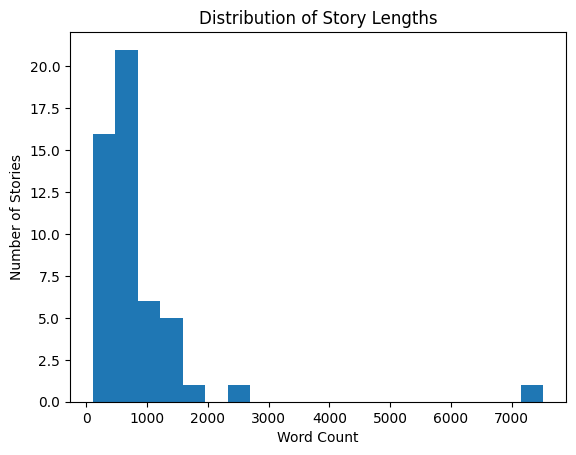

Sample cleaned text:
 Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER
Final Entity Dictionary (sample):
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC
Saved final entity dictionary to 'final_enti

Map: 100%|██████████| 409/409 [00:00<00:00, 17284.51 examples/s]


Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49212, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10})
Weight tensor: tensor([2.0320e-05, 2.5575e-03, 9.0909e-02, 2.2222e-02])



Some weights of CustomXLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_49603/1809248619.py:369: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...


Epoch,Training Loss,Validation Loss


: 

In [4]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
# Allow MPS to use up to 90% of available memory.
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.9"
import torch

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter
import csv

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('words')

# Determine device (MPS if available, otherwise CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:\n", df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUALLY CURATED CANDIDATE CSV
############################################

try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    # Standardize keys: strip and lowercase; fix any stray labels (e.g., "B-O" to "O")
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip().replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"  # Default scraped personal names as B-PER
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"  # Default scraped town names as B-LOC

print("Final Entity Dictionary (sample):")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS USING ENTITY DICTIONARY (BIO FORMAT)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    # Split only on the first hyphen in case there are extra dashes in the entity type.
    entity_type = label.split("-", 1)[-1]
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN/VALIDATION & CREATE DATASETS
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define your label list – using our standard BIO tags (adjust if needed)
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# To reduce undesired subword splitting, add special tokens from our entity dictionary.
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added:", num_added)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                label_str = example_labels[wid]
                # Merge contiguous subword tokens: if same word index, convert B- to I-
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False  # Disable caching to save disk space
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 10. SHOW LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)

# Compute weights for each label as 1/(count+1)
weight_list = [1.0 / (label_counts.get(lbl, 0) + 1) for lbl in label_list]
weight_tensor = torch.tensor(weight_list, dtype=torch.float)
print("Weight tensor:", weight_tensor)

############################################
# 11. CUSTOM MODEL CLASS TO REMOVE EXTRA KEYWORDS
############################################

# Create a custom subclass to override forward() so that it ignores the unexpected keyword argument.
from transformers.models.xlm_roberta.modeling_xlm_roberta import XLMRobertaForTokenClassification

class CustomXLMRobertaForTokenClassification(XLMRobertaForTokenClassification):
    def forward(self, *args, **kwargs):
        # Remove unexpected keyword 'num_items_in_batch' if present.
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

# Instantiate our custom model:
model = CustomXLMRobertaForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.resize_token_embeddings(len(tokenizer))  # Resize embeddings to account for new special tokens

############################################
# 12. TRAIN THE CUSTOM NER MODEL
############################################

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        temp_true_labels = []
        temp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            temp_true_labels.append(id2label[l_i])
            temp_true_preds.append(id2label[p_i])
        if temp_true_labels:
            true_labels.append(temp_true_labels)
            true_preds.append(temp_true_preds)
    if len(true_labels) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    results = seqeval.compute(predictions=true_preds, references=true_labels, zero_division=0)
    return {
        "precision": results.get("overall_precision", 0.0),
        "recall": results.get("overall_recall", 0.0),
        "f1": results.get("overall_f1", 0.0),
        "accuracy": results.get("overall_accuracy", 1.0)
    }

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

# Clear MPS cache if available
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=1,       # Lower batch size for MPS
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    logging_steps=50,
    fp16=False,                          # fp16 disabled on MPS
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\nStarting training...")
trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

############################################
# 13. INFERENCE
############################################

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))
